<h1>Performing hyperparameter tuning of XgBoost models using RandomsearchCV with vectorizer as TF-IDF W2V to reduce the log-loss</h1>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

from sklearn.preprocessing import MinMaxScaler

from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

from collections import Counter, defaultdict
from scipy.sparse import hstack

from sqlalchemy import create_engine # database connection

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

#import warnings
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")

<h2> 3.1 Reading data from file and getting ready for applying ML Models </h2>

In [3]:
from warnings import simplefilter
#from sklearn.exceptions import SettingWithCopyWarning
simplefilter("ignore")#, category=SettingWithCopyWarning)

data= pd.read_csv("final_features.csv")
data_subsampled = data[0:100001]
data_subsampled.drop(data_subsampled.index[0], inplace=True)
y_true = data_subsampled['is_duplicate']
data_subsampled.drop(['Unnamed: 0', 'id','is_duplicate'], axis=1, inplace=True)

data_subsampled.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
1,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,...,52.709532,-95.671132,-170.067806,26.612908,38.987457,2.798924,-148.537387,41.175455,-0.956987,185.971402
2,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,...,93.693241,-187.158916,-121.757270,36.766723,87.547771,9.056310,-70.108888,62.434596,-14.586129,41.213618


<h2>3.2 Converting strings to numerics</h2>

In [4]:
# after we read from file each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data_subsampled.columns)
for i in cols:
    data_subsampled[i] = data_subsampled[i].apply(pd.to_numeric)
    print(i)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
0_x
1_x
2_x
3_x
4_x
5_x
6_x
7_x
8_x
9_x
10_x
11_x
12_x
13_x
14_x
15_x
16_x
17_x
18_x
19_x
20_x
21_x
22_x
23_x
24_x
25_x
26_x
27_x
28_x
29_x
30_x
31_x
32_x
33_x
34_x
35_x
36_x
37_x
38_x
39_x
40_x
41_x
42_x
43_x
44_x
45_x
46_x
47_x
48_x
49_x
50_x
51_x
52_x
53_x
54_x
55_x
56_x
57_x
58_x
59_x
60_x
61_x
62_x
63_x
64_x
65_x
66_x
67_x
68_x
69_x
70_x
71_x
72_x
73_x
74_x
75_x
76_x
77_x
78_x
79_x
80_x
81_x
82_x
83_x
84_x
85_x
86_x
87_x
88_x
89_x
90_x
91_x
92_x
93_x
94_x
95_x
0_y
1_y
2_y
3_y
4_y
5_y
6_y
7_y
8_y
9_y
10_y
11_y
12_y
13_y
14_y
15_y
16_y
17_y
18_y
19_y
20_y
21_y
22_y
23_y
24_y
25_y
26_y
27_y
28_y
29_y
30_y
31_y
32_y
33_y
34_y
35_y
36_y
37_y
38_y
39_y
40_y
41_y
42_y
43_y
44_y
45_y
46_y
47_y
48_y
49_y

In [5]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
# https://datascience.stackexchange.com/questions/62819/list-object-has-no-attribute-values-when-we-are-using-append-in-python
# Must read above link blog for converting list to int
y_true = list(map(int, y_true))

<h2> 3.3 Random train test split( 70:30) </h2>

In [6]:
X_train,X_test, y_train, y_test = train_test_split(data_subsampled, y_true, stratify=y_true, test_size=0.3)

In [7]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (70000, 218)
Number of data points in test data : (30000, 218)


In [8]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in test data ----------
Class 0:  0.3725333333333333 Class 1:  0.3725333333333333


<h3> 3.4 Plot the confusion_matrix and call this function when we need </h2>

In [9]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("green")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 3.5 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8888095946358818


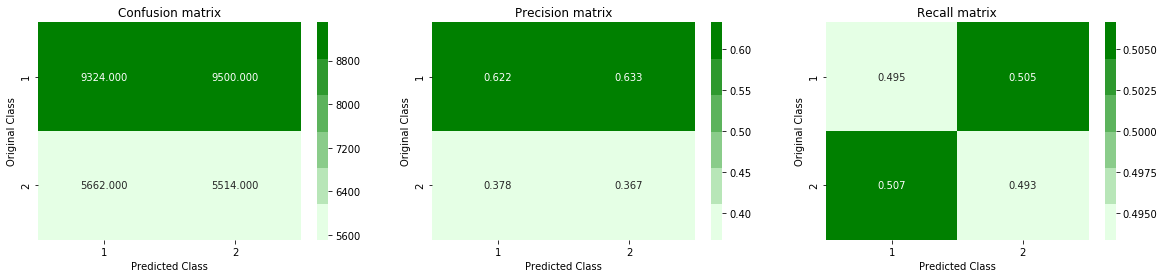

In [11]:
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 3.6 Applying XGBoost with hyperparameter tuning using RandomsearchCV </h2>

In [12]:
## For Hyper Parameter Optimization

param_grid = {
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'n_estimators': [50,100,150,200,300,400,500]}

In [13]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))



In [14]:
clf = xgb.XGBClassifier(nthread=-1)

In [15]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)
random_search=RandomizedSearchCV(clf,param_distributions=param_grid,n_iter=5,scoring='neg_log_loss',n_jobs=-1,cv=kfold,verbose=3,random_state=42)

In [16]:
from datetime import datetime
# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable

random_search.fit(X_train, y_train)

timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  25 | elapsed: 38.7min remaining: 49.3min
[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed: 47.3min remaining: 11.8min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 61.7min finished



 Time taken: 1 hours 5 minutes and 52.71 seconds.


In [20]:
# Summarize results
print("Best Score is: %f from using these combination of param_grid: %s"%(random_search.best_score_,random_search.best_params_))
print()
means = random_search.cv_results_['mean_test_score']
stds = random_search.cv_results_['std_test_score']
params = random_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("mean : %f, std : (%f) with param_grid : %r" % (mean, stdev, param))

Best Score is: -0.340121 from using these combination of param_grid: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}

mean : -0.548661, std : (0.001526) with param_grid : {'subsample': 0.7, 'n_estimators': 400, 'min_child_weight': 10.0, 'max_depth': 20, 'learning_rate': 0.001, 'gamma': 0, 'colsample_bytree': 0.9}
mean : -0.340121, std : (0.004853) with param_grid : {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
mean : -0.401012, std : (0.006009) with param_grid : {'subsample': 0.9, 'n_estimators': 100, 'min_child_weight': 5.0, 'max_depth': 20, 'learning_rate': 0.3, 'gamma': 0.25, 'colsample_bytree': 0.9}
mean : -0.523980, std : (0.001797) with param_grid : {'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3.0, 'max_depth': 20, 'learning_rate': 0.001, 'gamma': 0.25, 'colsample_bytree': 0.8}


In [46]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [47]:
random_search.best_params_

{'subsample': 0.7,
 'n_estimators': 100,
 'min_child_weight': 0.5,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 1.0,
 'colsample_bytree': 1.0}

<html>
<body><b>
<p style="color: #0099cc">SO, After Applying XGBoost with hyperparameter tuning using RandomsearchCV I got the best parameter for best score. Now, I am going to apply this best parameter to XGBClassifier to getting best logg loss score.</p>
</b></body>
</html>

The test log loss is: 0.33650175413096756
Total number of data points : 30000


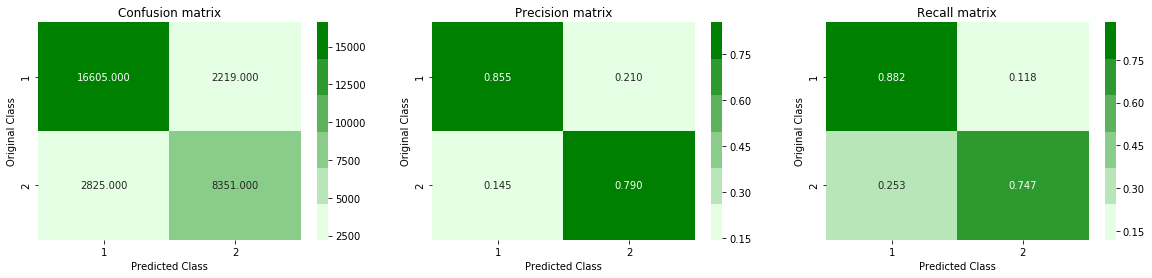

In [23]:
clf=xgb.XGBClassifier(n_jobs=-1,random_state=42,
                      max_depth=10,
                      n_estimators=100,
                      subsample= 0.7, 
                      min_child_weight= 0.5,
                      learning_rate= 0.1,
                      gamma=1.0,
                      colsample_bytree= 1.0)
clf.fit(X_train,y_train)

#predict_y = clf.predict_proba(X_train)
#print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = clf.predict_proba(X_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)